In [2]:
from data import Portfolio, Dataset
from utils import *
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
folio_params = {'assets': ['AAPL'],
                'start': '1990-01-01',
                'end': '2020-01-01',
                'returns': yf.Ticker('^DJI').history(start='1990-01-01',end='2020-01-01'),
                'name': '^DJI'}

# construct Portfolio object implemented in data.py
dji = Portfolio(**folio_params)

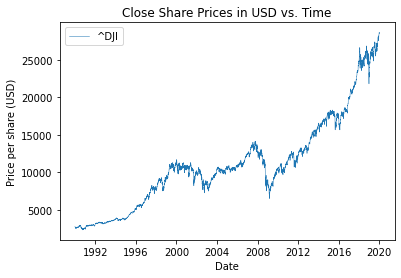

In [23]:
ax1 = dji.price_plot(['returns'],'Close',start,end)
plt.show()

In [25]:
# define feature names, target name, periods
feature_names = ['AAPL']
target_name = 'returns'
periods = list(range(1,21)) + list(range(40,260,20))
horizon = 5

params = {'pfolio_obj': dji, 
          'data_type': 'Close', 
          'feature_names': stock_list, 
          'periods': periods, 
          'horizon': horizon, 
          'target_name': 'returns', 
          'task_type': 'classification'}

# instantiate data object 
dji_data = Dataset(**params)

In [26]:
print("Number of features", dji_data.n_features)
print("Number of classes", dji_data.n_classes)
print("Number of datapoints", dji_data.n_samples)

Number of features 31
Number of classes 2
Number of datapoints 7313


In [29]:
display(dji_data.target.head())

Date
1990-12-13    1.0
1990-12-14    1.0
1990-12-17    1.0
1990-12-18    1.0
1990-12-19    0.0
Name: returns, dtype: float64

In [30]:
from sklearn.model_selection import GridSearchCV, train_test_split

def algorithm_pipeline(X_train_data, y_train_data, model, param_grid, cv=10, scoring_fit='roc_auc'):
    
    gs = GridSearchCV(estimator=model,param_grid=param_grid, cv=cv, n_jobs=-1, scoring=scoring_fit,verbose=2)
    
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    return fitted_model

In [32]:
from sklearn.linear_model import LogisticRegression

params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.001,0.01,0.1,1,10,100,1000]}

X = dji_data.data.to_numpy()
y = dji_data.target.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression()

best_clf = algorithm_pipeline(X_train, y_train, clf, params, cv=10)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 249 out of 280 | elapsed:    3.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    3.1s finished


In [34]:
print(best_clf.best_score_)
print(best_clf.best_params_)

0.5192579537315926
{'C': 1, 'penalty': 'l2'}


No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.531
No Skill: PR AUC=0.581
Logistic Regression: PR AUC=0.609


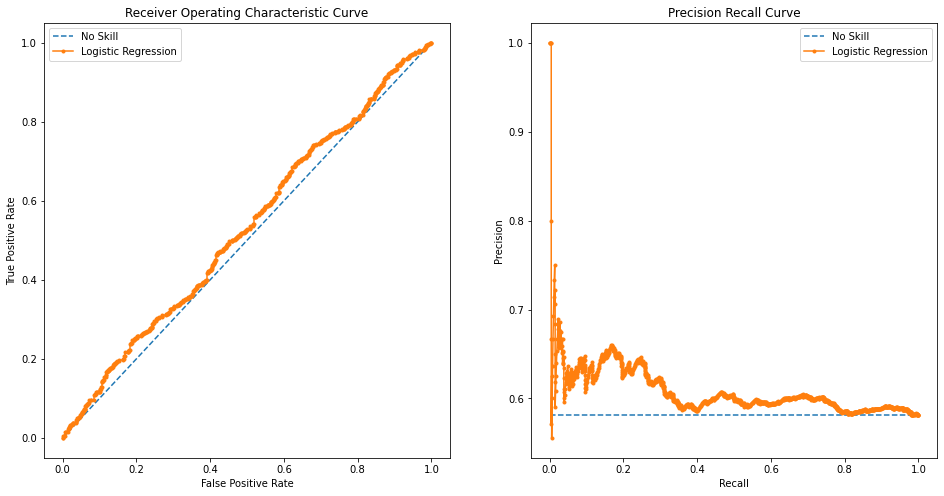

In [38]:
from sklearn import metrics

params = {'C': 1, 'penalty': 'l2'}

clf = LogisticRegression(**params)

clf.fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))

# predict probabilities
lr_probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# calculate scores
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
# plot the roc curve for the model
ax1.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax1.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
# axis labels
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic Curve')
# show the legend
ax1.legend()

# predict class values
yhat = clf.predict(X_test)
lr_precision, lr_recall, _ = metrics.precision_recall_curve(y_test, lr_probs)
lr_auc = metrics.auc(lr_recall, lr_precision)
# summarize scores
print('No Skill: PR AUC=%.3f' % (len(y_test[y_test==1]) / len(y_test)))
print('Logistic Regression: PR AUC=%.3f' % (lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
ax2.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression')
# axis labels
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision Recall Curve')
# show the legend
ax2.legend()

plt.show()